In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import re

plt.style.use('ggplot')
seed = 101

Load data.

In [2]:
comments = pd.read_csv('../data/toxicity_annotated_comments.tsv', sep='\t')
comments.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train
1,4216.0,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,2002,True,user,random,train
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test
3,26547.0,`This is such a fun entry. DevotchkaNEWLINE_...,2002,True,article,random,train
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test


In [3]:
comments.shape

(159686, 7)

In [4]:
annotations = pd.read_csv('../data/toxicity_annotations.tsv', sep='\t')
annotations.head()

,rev_id,worker_id,toxicity,toxicity_score
0,2232.0,723,0,0.0
1,2232.0,4000,0,0.0
2,2232.0,3989,0,1.0
3,2232.0,3341,0,0.0
4,2232.0,1574,0,1.0


In [5]:
annotations.shape

(1598289, 4)

Let's start by fixing some escaped characters: newline, tab, and quote (").

In [6]:
def fix_characters(text):
    text = re.sub(r'NEWLINE_TOKEN', '\n', text)
    text = re.sub(r'TAB_TOKEN', '\t', text)
    text = re.sub(r'`', '"', text)
    return text

comments['comment'] = comments['comment'].map(fix_characters)
comments.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,2232.0,This:\n:One can make an analogy in mathematica...,2002,True,article,random,train
1,4216.0,"""\n\n:Clarification for you (and Zundark's ri...",2002,True,user,random,train
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test
3,26547.0,"""This is such a fun entry. Devotchka\n\nI on...",2002,True,article,random,train
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test


Now that we have "clean" dataset, let's look at the distribution of comments and see if we see anything interesting.

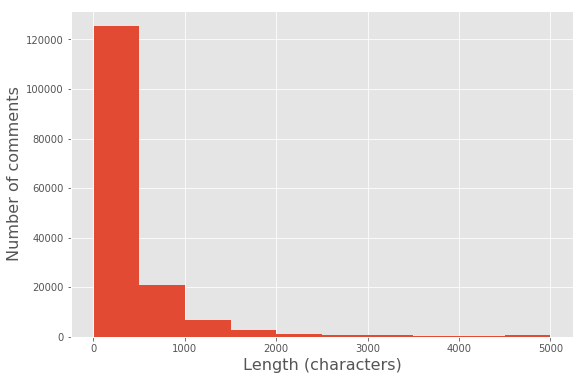

In [7]:
lengths = comments['comment'].map(len)

plt.figure(figsize=(9,6))
plt.hist(lengths)
plt.xlabel('Length (characters)', fontsize=16)
plt.ylabel('Number of comments', fontsize=16)
plt.show()

Do we have any duplicate comments?

In [8]:
unique_comments = comments.groupby('comment')['rev_id'].count().reset_index()
unique_comments[unique_comments['rev_id'] > 1].sort_values('rev_id', ascending=False).head()

,comment,rev_id
127769,"""\n==The Graceful Slick....==\nIs non other th...",8
136913,"""Thank you for experimenting with Wikipedia. ...",7
128433,"""\nWelcome\n\nHello and welcome to Wikipedia! ...",6
136915,"""Thank you for experimenting with Wikipedia. ...",6
152360,Thank you for experimenting with Wikipedia. Y...,5


Looks like there are some boilerplate messages. We may want to drop duplicates, but let's look at getting labels before we consider that. Each comment has multiple annotations, where the annotator has assigned a score. The score is based on a survey shown in the docs folder. The questions are as follows:

- Very toxic (a very hateful, aggressive, or disrespectful comment that is very likely to make you leave a discussion)
- Toxic (a rude, disrespectiful, or unreasonable comment that is somehwat likely to make you leave a discussion)
- Neither
- Healthy contribution (a reasonable, civil, or polite contribution that is somewhat likely to make you want to continue a discussion)
- Very healthly contribution (a very polite, throughful, or helpful contribution that is very likely to make you want to continue a discussion)

From top to bottom, the scores are -2, -1, 0, 1, and 2. We need to find a way to aggregate the toxicity_scores assigned to each comment. Also, what is the distribution of annotations over rev_id?

In [9]:
annotations.groupby('rev_id')['toxicity_score'].count().describe()

count    159686.000000
mean         10.008949
std           0.450793
min           8.000000
25%          10.000000
50%          10.000000
75%          10.000000
max          21.000000
Name: toxicity_score, dtype: float64

In [10]:
def agg_toxicity_scores(sub):
    result = {}
    result['min'] = sub['toxicity_score'].min()
    result['max'] = sub['toxicity_score'].max()
    result['avg'] = sub['toxicity_score'].mean()
    return pd.Series(result)

scores = annotations.groupby('rev_id').apply(agg_toxicity_scores).reset_index()
scores.head()

,rev_id,min,max,avg
0,2232.0,-1.0,1.0,0.4
1,4216.0,0.0,2.0,0.5
2,8953.0,0.0,1.0,0.1
3,26547.0,0.0,2.0,0.6
4,28959.0,-1.0,1.0,0.2


Now we can merge back into the comments dataframe.

In [11]:
df = pd.merge(comments, scores, on='rev_id')
df.head()

,rev_id,comment,year,logged_in,ns,sample,split,min,max,avg
0,2232.0,This:\n:One can make an analogy in mathematica...,2002,True,article,random,train,-1.0,1.0,0.4
1,4216.0,"""\n\n:Clarification for you (and Zundark's ri...",2002,True,user,random,train,0.0,2.0,0.5
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test,0.0,1.0,0.1
3,26547.0,"""This is such a fun entry. Devotchka\n\nI on...",2002,True,article,random,train,0.0,2.0,0.6
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test,-1.0,1.0,0.2


Before we go much further, let's take a look at some of the "toxic" comments. In theory, those with a max toxicity score of -2.0 should be the worst. Is that true?

In [12]:
idx = df['max'] == -2.0
df.loc[idx, 'comment'].sample(10, random_state=seed)

40815    YOU SUCK YOU SUCK YOU SUCK YOU SUCK YOU SUCK Y...
90280    FUCKING BITCHES THAT ARE READING THIS. JASENM2...
90685    NJGW IS AN UNEMPLOYED MOTHER FUCKING BASTARD L...
59017    \n\n== jerk me jolly ==\n\nfuckfuckfuckfuckfuc...
29133    \n\nFUCKING COCKSUCKING ADMINS, EAT MY SHIT CU...
98873    \n\n\n==You Cunt ==\nGo fuck yourself you piec...
51127    \n\n\nFUCK OFFFUCK OFFFUCK OFFFUCK OFFFUCK OFF...
76810    \n\n==Fuck You==\n\nGo suck on a fat dick fagg...
81942    SUCK MY COCK D SUCK MY COCK D SUCK MY COCK D S...
79522    YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A...
Name: comment, dtype: object

Yup. All terrible. What about the other end? In theory, those with a min toxicity score of 2.0 should be the best. Is that true?

In [13]:
idx = df['min'] == 2.0
idx.sum()

0

Ironically, _nobody_ has a min toxicity score equal to 2.0. I guess the bar is just higher for good content. Let's look at the distribution of the mean toxicity score and try to find a few with high marks.

In [14]:
df['avg'].quantile([0.9, 0.95, 0.99])

0.90    0.7
0.95    0.8
0.99    1.0
Name: avg, dtype: float64

In [15]:
idx = df['avg'] >= 1.0
df.loc[idx, 'comment'].sample(10, random_state=seed)

68722     "\n::We might want to consider redirecting it ...
143203    "\n:sorry for reverting you! I did not mean to...
152634    "\n\n== Please correct two of the contribution...
136008    \n\n* DDD. Thank you  for your time and effort...
81762                 Thanks for fixing the problem.   \n\n
155267    \n\n==Hi==\nHey Ebyabe... Look listen... I'm s...
26909     \ni am sorry for any trouble i have caused. My...
89714     \n:Civility please. That link is the place whe...
113806    \n::::That's good by me then, Gabriel. Thanks ...
8590      Welcome!\n\nHello , and welcome to Wikipedia! ...
Name: comment, dtype: object

Interesting. At least a few of these comments are an appeal for civility. Now that we have a better understanding of what constitutes the two classes, we need to make a decision about our target. A safe bet is to group everything with a mean score equal to or above 0.0 as a non-toxic message.

In [16]:
df['y'] = df['avg'].map(lambda x: int(x < 0))
df.head()

,rev_id,comment,year,logged_in,ns,sample,split,min,max,avg,y
0,2232.0,This:\n:One can make an analogy in mathematica...,2002,True,article,random,train,-1.0,1.0,0.4,0
1,4216.0,"""\n\n:Clarification for you (and Zundark's ri...",2002,True,user,random,train,0.0,2.0,0.5,0
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test,0.0,1.0,0.1,0
3,26547.0,"""This is such a fun entry. Devotchka\n\nI on...",2002,True,article,random,train,0.0,2.0,0.6,0
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test,-1.0,1.0,0.2,0


In [17]:
df['y'].value_counts(normalize=True)

0    0.815532
1    0.184468
Name: y, dtype: float64

Roughly 18.5% of all comments are toxic. Now that we have labels, let's revisit the comments. First, we need to break up the text into tokens. Let's start by grabbing all alpha tokens. How many unique tokens are in the comments?

In [18]:
def tokenize(text):
    return re.findall(r'[a-zA-Z]+', text)

idx_train = df['split'] == 'train'
idx_dev = df['split'] == 'dev'
idx_test = df['split'] == 'test'

token_dict = {}
for comment in tqdm(df.loc[idx_train, 'comment']):
    tokens = tokenize(comment)
    for token in tokens:
        if token in token_dict:
            token_dict[token] += 1
        else:
            token_dict[token] = 1

len(token_dict)

100%|█████████████████████████████████████████████████████████████████████████| 95692/95692 [00:03<00:00, 25855.70it/s]


157978

Let's look at some tokens that only show up once.

In [19]:
one_hit_wonders = [token for token, count in token_dict.items() if count == 1]
rng = np.random.RandomState(seed)
for i in rng.randint(0, len(one_hit_wonders)+1, 20):
    print(one_hit_wonders[i])

LEITMOTIV
garish
Wessonsuoum
Manduca
Ioannis
eSearchServer
AynRand
DengXiaoPing
HIPAA
HAAHA
Maathai
TheUnbelieveableTruth
Zapecptyltd
Ttiotsw
gymnasts
eOoFAAAAIBAJ
distiller
accidentaly
willpower
Gidon


That is a _lot_ of features. What happens if we allow alphanumeric tokens?

In [20]:
def tokenize(text):
    return re.findall(r'[a-zA-Z0-9]+', text)

token_dict = {}
for comment in tqdm(df.loc[idx_train, 'comment']):
    tokens = tokenize(comment)
    for token in tokens:
        if token in token_dict:
            token_dict[token] += 1
        else:
            token_dict[token] = 1

len(token_dict)

100%|█████████████████████████████████████████████████████████████████████████| 95692/95692 [00:03<00:00, 25946.84it/s]


166277

It actually doesn't blow things up too much. What do those alphanumeric tokens look like?

In [21]:
numeric_tokens = []
for token in tqdm(token_dict.keys()):
    if np.any([c.isnumeric() for c in token]):
        numeric_tokens.append(token)

100%|██████████████████████████████████████████████████████████████████████| 166277/166277 [00:01<00:00, 159568.17it/s]


In [22]:
rng = np.random.RandomState(seed)
for i in rng.randint(0, len(numeric_tokens)+1, 20):
    print(numeric_tokens[i])

9am
McFly85
b1
Z500
237
1253471852
P3P
misc2
H1N1
age2
10s
app1
TV2
or3
archive5
101202
01929
P56
1899
451b


It's not clear that we would need these tokens, and the truth is that numeric tokens can quickly blow up your feature space. Let's exclude them and try to reduce the overall number of tokens by casting everything to lowercase.

In [23]:
def tokenize(text):
    return re.findall(r'[a-z0-9]+', text.lower())

token_dict = {}
for comment in tqdm(df.loc[idx_train, 'comment']):
    tokens = tokenize(comment)
    for token in tokens:
        if token in token_dict:
            token_dict[token] += 1
        else:
            token_dict[token] = 1

len(token_dict)

100%|█████████████████████████████████████████████████████████████████████████| 95692/95692 [00:03<00:00, 25082.79it/s]


132883

In [24]:
one_hit_wonders = [token for token, count in token_dict.items() if count == 1]
rng = np.random.RandomState(seed)
for i in rng.randint(0, len(one_hit_wonders)+1, 20):
    print(one_hit_wonders[i])

treatening
aljazeerah
ghaddar
ltl
anexpert
balija
copyied
pitting
glenna
contraband
lutch
kangaroos
bhattara
cabiai
centimetres
mcw
wau
complte
arduino
yapped


Now let's consider some n-grams. This is built into scikit-learn vectorizers, but let's code something from python primatives to show what's going on behind the scenes.

In [25]:
def get_ngrams(tokens, n=2):
    ngrams = zip(*[tokens[i:] for i in range(n)])
    ngrams = [' '.join(ngram) for ngram in ngrams]
    return ngrams

def tokenize(text, ngram_range=(1,1)):
    tokens = re.findall(r'[a-z0-9]+', text.lower())
    ngrams = []
    for n in range(ngram_range[0], ngram_range[1]+1):
        ngrams += get_ngrams(tokens, n)
    return ngrams

test = '''This is a test sentence.'''
tokens = tokenize(test, (1,3))
tokens

['this',
 'is',
 'a',
 'test',
 'sentence',
 'this is',
 'is a',
 'a test',
 'test sentence',
 'this is a',
 'is a test',
 'a test sentence']

Let's start with unigrams and bigrams. How large will the feature set get?

In [26]:
token_dict = {}
for comment in tqdm(df.loc[idx_train, 'comment']):
    tokens = tokenize(comment, ngram_range=(1,2))
    for token in tokens:
        if token in token_dict:
            token_dict[token] += 1
        else:
            token_dict[token] = 1

len(token_dict)

100%|██████████████████████████████████████████████████████████████████████████| 95692/95692 [00:10<00:00, 9400.92it/s]


1633605

Unigrams and Bigrams led to a 10X increase in features! What do some of these bigrams look like?

In [27]:
bigrams = [token for token in tqdm(token_dict.keys()) if len(token.split(' ')) > 1]
rng = np.random.RandomState(seed)
for i in rng.randint(0, len(bigrams)+1, size=20):
    print(bigrams[i])

100%|███████████████████████████████████████████████████████████████████| 1633605/1633605 [00:01<00:00, 1497347.34it/s]


simon wicks
at hematology
blagden everard
as redirects
rescued i
said ifd
in prominence
been entrusted
moroccan origin
both elagant
grammar mercury
this elven6
the thin
sir i
world exploiting
wad with
paul tsongas
punch it
population no
was currently


What percentage of these bigrams are one-off?

In [28]:
bigram_counts = [token_dict[bigram] for bigram in tqdm(bigrams)]
pd.value_counts(bigram_counts, normalize=True).head()

100%|███████████████████████████████████████████████████████████████████| 1500722/1500722 [00:00<00:00, 2009000.64it/s]


1    0.715386
2    0.121917
3    0.047081
4    0.025708
5    0.015725
dtype: float64

Clearly, a ton of these will need to be removed. What happens if we add trigrams?

In [29]:
token_dict = {}
for comment in tqdm(df.loc[idx_train, 'comment']):
    tokens = tokenize(comment, ngram_range=(1,3))
    for token in tokens:
        if token in token_dict:
            token_dict[token] += 1
        else:
            token_dict[token] = 1

len(token_dict)

100%|██████████████████████████████████████████████████████████████████████████| 95692/95692 [00:15<00:00, 6159.35it/s]


5259368

Wow, 5.25 million unigrams, bigrams, and trigrams. Let's look at a few of them.

In [30]:
trigrams = [token for token in tqdm(token_dict.keys()) if len(token.split(' ')) == 3]
rng = np.random.RandomState(seed)
for i in rng.randint(0, len(trigrams)+1, size=20):
    print(trigrams[i])

100%|███████████████████████████████████████████████████████████████████| 5259368/5259368 [00:03<00:00, 1623240.58it/s]


of the bangla
no easy matter
bring my friend
s interest i
simply asserts why
more if you
form that has
tag he deleted
either a not
wonder why espn
being committed the
requests are still
list the density
insider connected to
calculate an overall
talk henry burrell
article writer but
edit else i
all i happen
4 20 98


Okay, so clearly we need some method of choosing which features to keep. Let's make a small modification to the token counts so that we can look at _document frequency_. We'll start with unigrams and bigrams.

In [31]:
def get_ngrams(tokens, n=2):
    ngrams = zip(*[tokens[i:] for i in range(n)])
    ngrams = [' '.join(ngram) for ngram in ngrams]
    return ngrams

def tokenize(text, ngram_range=(1,1)):
    tokens = re.findall(r'[a-z0-9]+', text.lower())
    ngrams = []
    for n in range(ngram_range[0], ngram_range[1]+1):
        ngrams += get_ngrams(tokens, n)
    return ngrams

df_token_dict = {}
for comment in tqdm(df.loc[idx_train, 'comment']):
    tokens = tokenize(comment, (1,2))
    for token in set(tokens):
        if token in df_token_dict:
            df_token_dict[token] += 1
        else:
            df_token_dict[token] = 1

len(df_token_dict)

100%|██████████████████████████████████████████████████████████████████████████| 95692/95692 [00:10<00:00, 9390.76it/s]


1633605

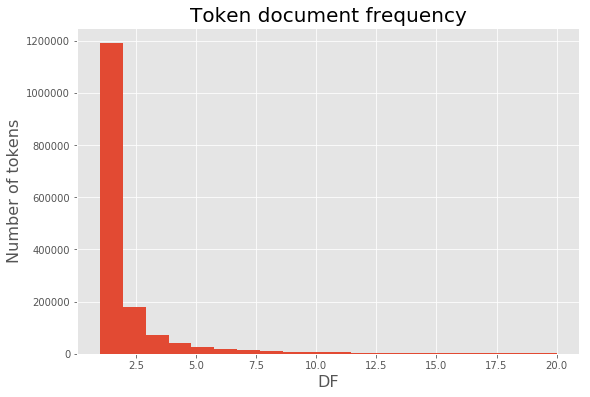

In [32]:
dfs = list(df_token_dict.values())

plt.figure(figsize=(9,6))
plt.hist(dfs, bins=20, range=(1,20))
plt.title('Token document frequency', fontsize=20)
plt.xlabel('DF', fontsize=16)
plt.ylabel('Number of tokens', fontsize=16)
plt.show()

In [33]:
pd.value_counts(dfs, normalize=True).head()

1    0.728658
2    0.109755
3    0.044161
4    0.024284
5    0.015263
dtype: float64

Threshold is obviously going to have a large effect on the total vocabulary. Is throwing out low-frequency terms going to affect the model performance? Let's look at the distribution of token lengths.

In [34]:
tokens = list(df_token_dict.keys())
token_len = np.array([len(token) for token in tokens])
token_len

array([ 9, 11, 11, ..., 12, 17, 10])

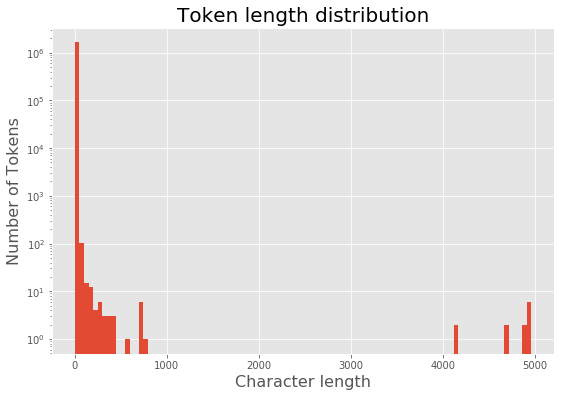

In [35]:
plt.figure(figsize=(9,6))
plt.hist(token_len, bins=100)
plt.title('Token length distribution', fontsize=20)
plt.xlabel('Character length', fontsize=16)
plt.ylabel('Number of Tokens', fontsize=16)
plt.yscale('log')
plt.show()

Strange that there are some _very_ long tokens. What do they look like?

In [36]:
for token in tokens:
    if len(token) > 4000:
        print(token)

crapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrap

banned crapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapcrapc

fuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuck

gay fuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuck

cunt wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww

wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww

hyyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyu

weak hyyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuy

yyyyyyyyyyyyyyybvgtfrrrrrbyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy

apocalypse yyyyyyyyyyyyyyybvgtfrrrrrbyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy

god tytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytyty

tytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytytyty

I'm guessing these tokens don't contribute much to discussions, but could we use some character level ngrams to handle these situations?

In [37]:
def get_char_ngrams(token, n=2):
    char_ngrams = zip(*[token[i:] for i in range(n)])
    char_ngrams = [''.join(char_ngram) for char_ngram in char_ngrams]
    return char_ngrams

def tokenize(text, char_ngram_range=(1,1)):
    tokens = re.findall(r'[a-z0-9]+', text.lower())
    char_ngrams = []
    for token in tokens:
        for n in range(char_ngram_range[0], char_ngram_range[1]+1):
            char_ngrams += get_char_ngrams(token, n)
    return char_ngrams

test = 'this is a sentence about a banana'
tokenize(test, char_ngram_range=(2,3))

['th',
 'hi',
 'is',
 'thi',
 'his',
 'is',
 'se',
 'en',
 'nt',
 'te',
 'en',
 'nc',
 'ce',
 'sen',
 'ent',
 'nte',
 'ten',
 'enc',
 'nce',
 'ab',
 'bo',
 'ou',
 'ut',
 'abo',
 'bou',
 'out',
 'ba',
 'an',
 'na',
 'an',
 'na',
 'ban',
 'ana',
 'nan',
 'ana']

What does the feature space look like for these character ngrams? Let's start with 2 and 3 grams (likely, we'd see unigrams across all comments).

In [38]:
df_token_dict = {}
for comment in tqdm(df.loc[idx_train, 'comment']):
    tokens = tokenize(comment, (2,3))
    for token in set(tokens):
        if token in df_token_dict:
            df_token_dict[token] += 1
        else:
            df_token_dict[token] = 1

len(df_token_dict)

100%|██████████████████████████████████████████████████████████████████████████| 95692/95692 [00:36<00:00, 2612.46it/s]


22573

The feature space is really pretty small. What's the distribution look like?

In [39]:
dfs = list(df_token_dict.values())
pd.value_counts(dfs, normalize=True).head()

1    0.293847
2    0.115669
3    0.064812
4    0.039649
5    0.028707
dtype: float64

Much flatter. Let's expand the char_ngram range out to 4, to allow for certain 4-letter words.

In [40]:
df_token_dict = {}
for comment in tqdm(df.loc[idx_train, 'comment']):
    tokens = tokenize(comment, (2,4))
    for token in set(tokens):
        if token in df_token_dict:
            df_token_dict[token] += 1
        else:
            df_token_dict[token] = 1

len(df_token_dict)

100%|██████████████████████████████████████████████████████████████████████████| 95692/95692 [00:53<00:00, 1788.67it/s]


111142

In [41]:
dfs = list(df_token_dict.values())
pd.value_counts(dfs, normalize=True).head()

1    0.397995
2    0.129762
3    0.067976
4    0.041757
5    0.030978
dtype: float64

Interesting, the feature space is still not very large. The truth is that all this exploration is useful, but the best indication of feature importance is downstream performance. Before we go, let's dump the dataframe into a sqlite database so we don't have to reprocess everything.

In [42]:
import sqlite3 as sql
import os

if not os.path.isfile('../data/toxic.db'):
    with sql.connect('../data/toxic.db') as conn:
        df.to_sql('toxic', conn, index=False)